<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson1_FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Neural Network Models

In this tutorial, we will learn how to use a neural network (NN) model to predict the energy of points on the Müller-Brown potential energy surface.



In [1]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Defining the Müller-Brown Potential Energy Function

For the definition of Müller-Brown potential, see [here](https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.).

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

In [2]:
def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    # Scale the function by 0.1 to make plotting easier.
  return value

### Generate Training Data

First, we need to generate data to train the neural network. The training data will be generated using the Müller-Brown Potential and a range of x and y values.

In [3]:
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
for y in yy:
  for x in xx:
    v = mueller_brown_potential(x,y) # Now using x and y values from the xx and yy arrays.
    z.append(v) # Storing potential energy values in the z array.
    xy.append([x,y])
    if v < 10:  # Keep only low-energy points for training.
      xy_truncated.append([x, y])
      z_truncated.append(v)
Z = np.reshape(z,(len(yy),-1)) # Reshape z array so that we can plot our data on a 2-D surface that is len(xx) by len(yy).
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of Testing set:", len(z))
print("Size of (future) training set:", len(z_truncated))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of Testing set: 896
Size of (future) training set: 696


### Visualizing Training Data: 3-D Projection Surface

We will now create a 3-D plot of our training data. To make the plot more readable, we will replace the points that have extremely high energy with nan (not a number). This will keep our $Z$ array the same shape and help us ignore the high energy region that we are not interested in.

In [4]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

### Visualizing Training Data: 3-D Projection Surface

Since we are only keeping the low-energy points for training (v$<$10, see [1.1.1]), we will make a 3-D surface plot that more accurately reflects our training data.

In [5]:
import copy

clean_Z = copy.copy(Z)
clean_Z[clean_Z>10] = np.nan

fig = go.Figure(data=[go.Surface(z=clean_Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

### Visualizing Training Data: Contour Surface

To allow for an easier visualization of the potential energy surface, we can generate a 2-D contour surface.

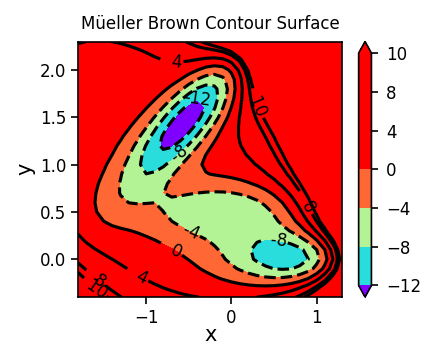

In [6]:
fig = plt.figure(figsize=(3,2.5), dpi=150)
levels = [-12, -8, -4, 0, 4, 8, 10]
ct = plt.contour(X, Y, Z, levels, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
plt.xlabel("x", labelpad=-0.75)
plt.ylabel("y", labelpad=2.5)
plt.tick_params(axis='both', pad=2,labelsize=8)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
plt.title('Müeller Brown Contour Surface', fontsize=8)
plt.tight_layout()
plt.show()

## Loading PyTorch and Training Data

After installing and importing pytorch, we will save our training data as a tensor data set.


In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
print("Size of training set:", len(train_loader.dataset))

Size of training set: 696


### A Basic Neural Network

Below is a schematic of a neural network. Inputs ($x$, $y$) are given weights ($w$). For each neuron in the hidden layer a bias ($b$) is added to the weighted inputs to generate a value ($v$) for the activation function (tanh). The activation function decides the activity ($v'$) of each neuron in the hidden layer. Weights ($w'$), biases ($b'$), and the activation function on the neuron of the output layer produces the prediction ($V^{pred}$).

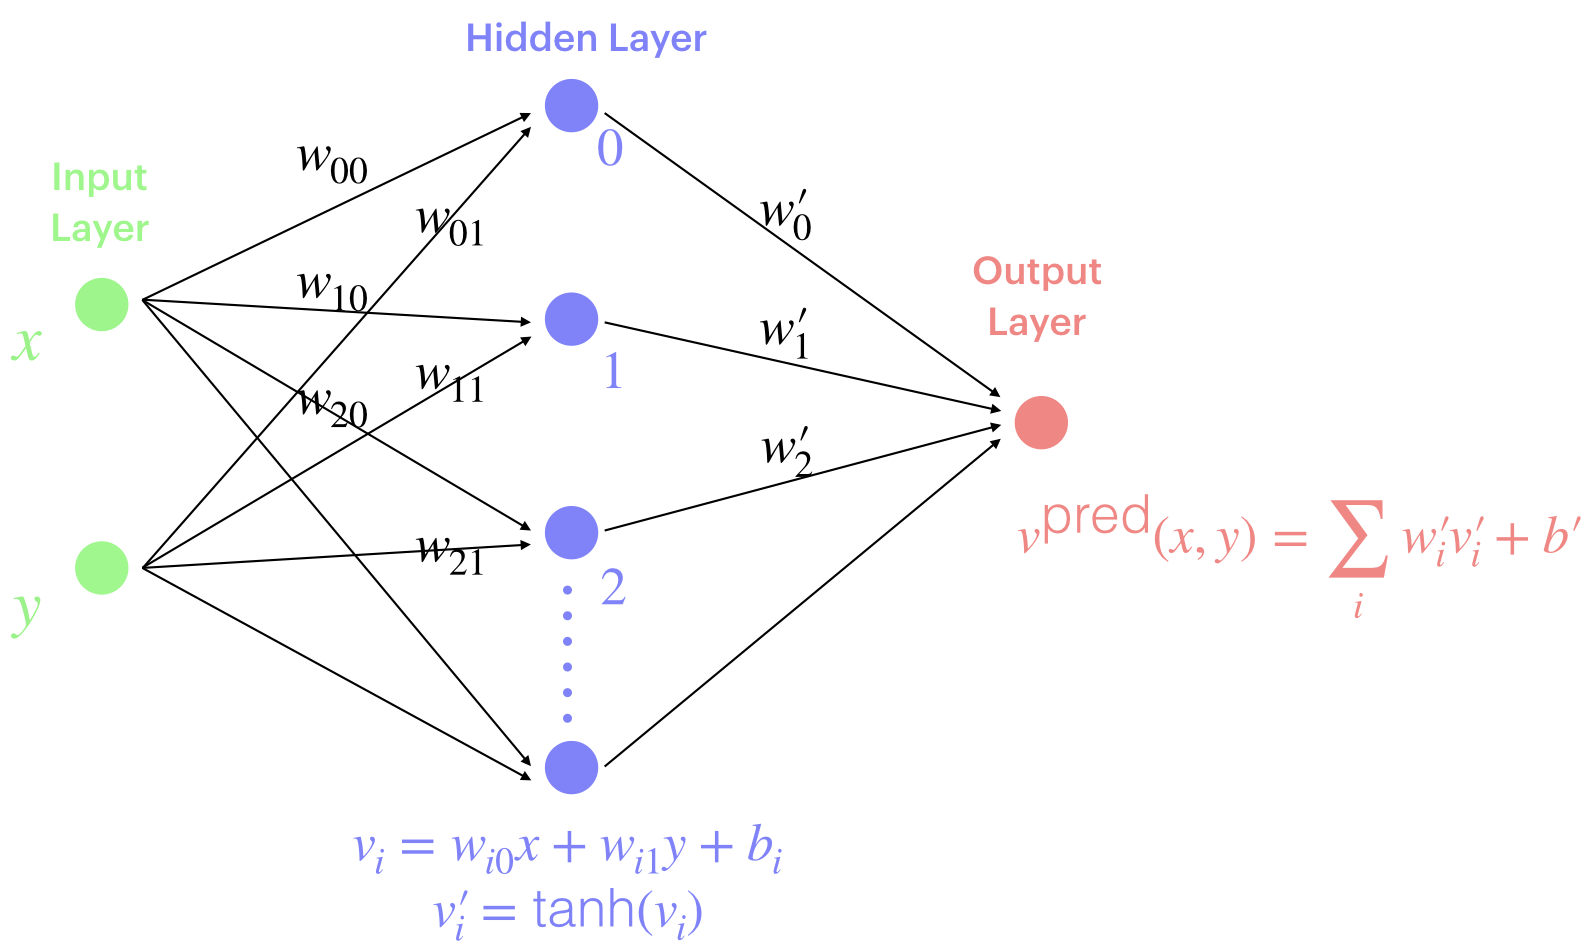

## Defining the Neural Network Class

Here we define our neural network as a Python class. A function ($\it{train\_loop}$) is used to loop through our training data.

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, n1=20):  #n1 is the number of neurons for the first layer
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1), # Linear function taking 2 inputs and outputs data for 20 neurons.
            nn.Tanh(),
            nn.Linear(n1, 1) # Linear function taking data from 20 neurons and producing one output value.
        )

    def forward(self, x):
        return self.model(x)

def train_loop(dataloader, model, optimizer, i_epoch):

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = F.mse_loss(pred.squeeze(), y)

        # Backpropagation - using the loss function gradients to update the weights and biases.
        optimizer.zero_grad() # Zero out the gradients from the previous iteration to replace them.
        loss.backward() # Update the gradients of the loss function.
        optimizer.step() # Uses step() to optimize the weights and biases with the updated gradients.

        if batch % 15 == 0 and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]")

## Training the Model

Now we can train the neural network model. We will finish our training when the desired number of epochs has been reached. We will also define some terms used for training below. \

Epochs - Number of forward/backward passes through the entire neural network.

Learning Rate - Determines the step size as we try to minimize the loss function. A faster learning rate would have a larger step size. \

Stochastic Gradient Descent (SGD) - The algorithm used for minimizing the loss function.

In [9]:
learning_rate = 1e-2
epochs = 1000
n1 = 20
model = NeuralNetwork(n1)
loss_fn = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    train_loop(train_loader, model, optimizer, t)
    # Note: In this example, there are 696 training points broken into 21 batches of batch size 32 (672 training points).
    # That means there is an extra batch of 24 training points. When added together, this gives the full 696 training points.
print("Done with Training!")

epoch:   0 loss:  32.151  [    0/  696]
epoch:   0 loss:  21.806  [  480/  696]
epoch: 100 loss:   2.026  [    0/  696]
epoch: 100 loss:   7.977  [  480/  696]
epoch: 200 loss:   3.471  [    0/  696]
epoch: 200 loss:   2.072  [  480/  696]
epoch: 300 loss:   1.887  [    0/  696]
epoch: 300 loss:   1.262  [  480/  696]
epoch: 400 loss:   0.600  [    0/  696]
epoch: 400 loss:   1.683  [  480/  696]
epoch: 500 loss:   0.984  [    0/  696]
epoch: 500 loss:   1.547  [  480/  696]
epoch: 600 loss:   1.253  [    0/  696]
epoch: 600 loss:   0.653  [  480/  696]
epoch: 700 loss:   0.500  [    0/  696]
epoch: 700 loss:   1.457  [  480/  696]
epoch: 800 loss:   0.454  [    0/  696]
epoch: 800 loss:   0.947  [  480/  696]
epoch: 900 loss:   0.590  [    0/  696]
epoch: 900 loss:   0.615  [  480/  696]
Done with Training!


## Plotting Reference, Predicted, and Difference Surfaces

Finally, we will plot the Müller-Brown potential energy surface using the analytical function (reference), using the neural network (predicted), and we will show the difference between the predicted and reference surfaces.

diff, min, max: -1177.3275941757859 3.5389141778921864


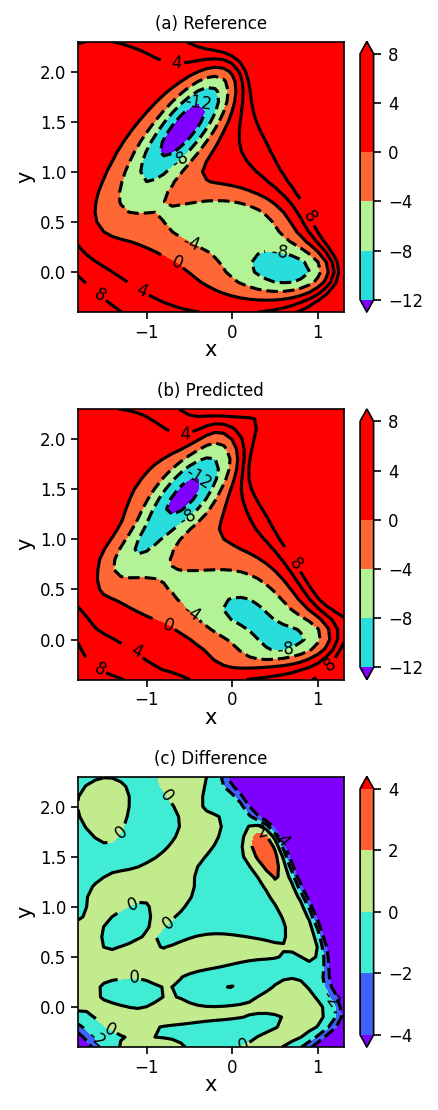

In [10]:
def show_surface(model):

  z_pred = model(Tensor(xy))
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)

  fig = plt.figure(figsize=(3,7.5), dpi=150)


  plt.subplot(3, 1, 1)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("(a) Reference", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)

  plt.subplot(3, 1, 2)
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("(b) Predicted", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)


  plt.subplot(3, 1, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("(c) Difference", fontsize=8)
  plt.xlabel("x", labelpad=-0.75)
  plt.ylabel("y", labelpad=2.5)
  print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
  plt.tick_params(axis='both', pad=2,labelsize=8)
  cbar= plt.colorbar()
  cbar.ax.tick_params(labelsize=8)

  plt.tight_layout()

  plt.show()

show_surface(model)

## Taking a Look at the Neural Network parameters

In order to take a closer look at the neural network parameters, we will plug them into the linear functions.

In [11]:
print("model:", model)

for name, param in model.named_parameters():
    if name == 'model.0.weight': weights0 = param.data.detach().numpy()
    elif name == 'model.0.bias': bias0 = param.data.detach().numpy()
    elif name == 'model.2.weight': weights2 = param.data.detach().numpy()
    elif name == 'model.2.bias': bias2 = param.data.detach().numpy()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# First linear function
v1 = np.zeros(n1)
for i in range(0, n1):
  v1[i] += weights0[i,0] * xy0[0] + weights0[i,1] * xy0[1] + bias0[i]

# Activation function
v2 = np.zeros(n1)
for i in range(0, n1):
  v2[i] = tanh(v1[i])

# Second linear function
z_pred = 0.0
for i in range(0, n1):
  z_pred += weights2[0,i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

model: NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)
z0: tensor([-13.4447], grad_fn=<AddBackward0>) z_pred: -13.444676935033286


## A More Automated/Refined Implementation

### Implementing a Neural Network with PyTorch-Lightning

Below is a more professional implementation of the neural network that saves epoch infromation in the logs_csv/ directory.

In [12]:
%pip install pytorch-lightning > /dev/null
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [13]:
%%capture
class pl_model(pl.LightningModule):
    def __init__(self, n1=20):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,n1),
            nn.Tanh(),
            nn.Linear(n1, 1)
        )
        self.learning_rate = 1e-2

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        loss = F.mse_loss(z_pred.squeeze(), z)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        # Using the Adam optimzation algorithm instead of SGD.
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # We can use the scheduler to adjust the learning rate.
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer]#, [scheduler]

csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=1000, logger=csv_logger)
n1 = 20
model = pl_model(n1)
trainer.fit(model, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 81    
-------------------------------------
81        Trainable params
0         Non-trainable params
81        Total params
0.000     Total estimated model params size (MB)


### Plotting Training Error

Now we can plot the training error as the number of epochs increases.
With more training iterations, we should see a decrease in the error of the model.


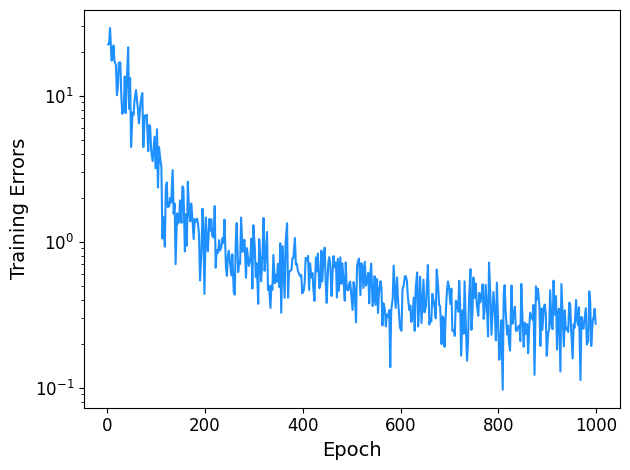

In [23]:
import pandas as pd
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"], color='dodgerblue')
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Training Errors", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

### Plotting Reference, Predicted, and Difference Surfaces

Again, we plot the reference, predicted, and difference surfaces using the more refined neural network implementation.


diff, min, max: -1157.1704667954148 4.254873280397252


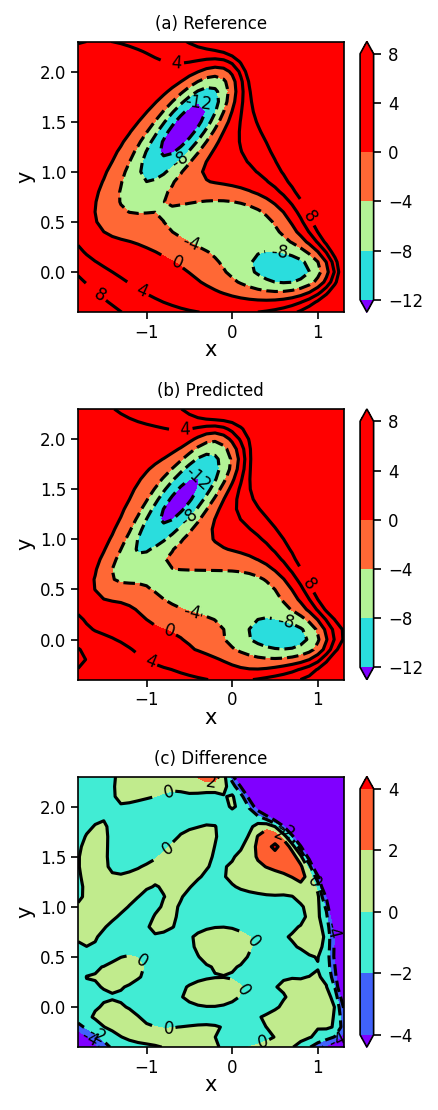

In [16]:
show_surface(model)